In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import fft
import seaborn as sns


In [ ]:
def rand_data(expmod = 1.0,len_in_pis = 3,return_values=False):
    start = int(np.random.uniform(0, 200))
    end = start + int(np.pi*1000*len_in_pis)
    x = np.arange(start,end)/1000
    y = np.sin(np.expm1(x*expmod)*expmod)
    if return_values:
        return y, start, end
    return y
data = None
import matplotlib.pyplot as plt
plt.plot(rand_data())
# for i in range(0,20):
#     data = rand_data(expmod=i/5)
runnum = 0


In [ ]:
import matplotlib as mp
import matplotlib.pyplot as plt
print(mp.get_backend())
%matplotlib inline
# f, t, Sxx = signal.spectrogram(data,)
# plt.pcolormesh(t, fftshift(f), fftshift(Sxx, axes=0))
# for i in range(1,5):    
#     print(i)
#     data = data + rand_data(i/1)
data = rand_data(0.5,len_in_pis=3)
plt.switch_backend("module://matplotlib_inline.backend_inline")
powerSpectrum, frequenciesFound, time, imageAxis = plt.specgram(data,NFFT=256*2,noverlap = 190,sides="onesided",pad_to=54)
plt.show()
print(f"{time.shape[0] = } | {frequenciesFound.shape[0] = } | {powerSpectrum.shape = }")
plt.pcolormesh(powerSpectrum)

In [ ]:
plt.plot(data)
plt.show()

In [ ]:
def return_sg(a,b,switch = "agg"):
    data = rand_data(a,len_in_pis=b)
    plt.switch_backend(switch) if switch != None else print("using a normal backend")
    powerSpectrum, frequenciesFound, time, _ = plt.specgram(
        data, NFFT=256*2, noverlap=190, sides="onesided", pad_to=54)
    return powerSpectrum
def plot_sg(data):
    plt.pcolormesh(data,shading="gouraud")
    plt.xlim(0,data.shape[0])
    # plt.colorbar(plt.gca().get_cmap(""),)

In [ ]:
import matplotlib.pyplot as plt
plt.switch_backend("module://matplotlib_inline.backend_inline")
print(plt.get_backend())
plot_sg(return_sg(-2,3,None))
plt.show()
plot_sg(return_sg(3,3,None))

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

In [ ]:
class specGds(Dataset):
    def __init__(self,num_samples:int,scale_factor:float,numpis = 3):
        self.slist = np.arange(1,num_samples+1,1,dtype=np.float64)
        self.slist *= scale_factor
        self.numpis = numpis
        print(self.__str__())
    def __len__(self):
        return len(self.slist)
    def __getitem__(self, index):
        np.random.seed(index)
        return torch.tensor(return_sg(self.slist[index], self.numpis), dtype=torch.float).view((1, 28, 28))
    def plotitem(self,index):
        plt.switch_backend("module://matplotlib_inline.backend_inline")
        plot_sg(self.__getitem__(index)[0])
        plt.show()
    def __str__(self) -> str:
        return f"{self.slist.shape = } | {self.numpis = } | {self.__len__() = }"

In [ ]:
data = specGds(1000,1/3000)
data.plotitem(1)
plt.show()


In [ ]:
dl = DataLoader(specGds(10000,1/3000),shuffle = True, batch_size=32)
plt.switch_backend("module://matplotlib_inline.backend_inline")
a = next(iter(dl))
print(a.shape)
del plt
import matplotlib.pyplot as plt
plt.switch_backend("module://matplotlib_inline.backend_inline")
plt.pcolormesh(a[0][0])
plt.plot()
# x = a.view((32,1,28,28))
# print(x.shape,x[0][0].shape)
# plt.pcolormesh(x[0][0])
# plt.plot()

# This is where the actual ML algo starts

In [ ]:
from ipywidgets import *

In [ ]:
import torch
import torch.nn as nn
from torch.nn import ConvTranspose2d
from torch.nn import BatchNorm2d
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import LeakyReLU
from torch.nn import ReLU
from torch.nn import Tanh
from torch.nn import Sigmoid
from torch import flatten
from torch import nn
from torch import optim
from torch.utils.data import DataLoader


In [209]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100, batchnorm=True):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.batchnorm = batchnorm
        # first set of CONVT => RELU => BN
        self.linear1 = nn.Linear(self.latent_dim, 256*7*7, bias=False)
        self.bn1d1 = nn.BatchNorm1d(256*7*7) if self.batchnorm else None
        self.leaky_relu = nn.LeakyReLU()

        # Convolutions
        self.conv1 = nn.Conv2d(
                in_channels=256,
                out_channels=128,
                kernel_size=5,
                stride=1,
                padding=2,
                bias=False)
        self.bn2d1 = nn.BatchNorm2d(128) if self.batchnorm else None

        self.conv2 = nn.ConvTranspose2d(
                in_channels=128,
                out_channels=64,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False)
        self.bn2d2 = nn.BatchNorm2d(64) if self.batchnorm else None

        self.conv2dot5 = nn.ConvTranspose2d(
                in_channels=64,
                out_channels=32,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False)
        self.bn2d2dot5 = nn.BatchNorm2d(32) if self.batchnorm else None

        self.conv3 = nn.ConvTranspose2d(
                in_channels=32,
                out_channels=16,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False)
        
        self.conv4 = nn.Conv2d(
            in_channels=16,
            out_channels=8,
            kernel_size=3,
            stride=2,
        )
        self.conv5 = nn.Conv2d(
            in_channels=8,
            out_channels=1,
            kernel_size=2,
            padding=1
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_tensor):
        """Forward pass; map latent vectors to samples."""
        intermediate = self.linear1(input_tensor)
        intermediate = self.bn1d1(intermediate)
        intermediate = self.leaky_relu(intermediate)
        intermediate = intermediate.view((-1, 256, 7, 7))

        intermediate = self.conv1(intermediate)
        if self.batchnorm:
            intermediate = self.bn2d1(intermediate)
        intermediate = self.leaky_relu(intermediate)

        intermediate = self.conv2(intermediate)
        if self.batchnorm:
            intermediate = self.bn2d2(intermediate)
        intermediate = self.leaky_relu(intermediate)

        intermediate = self.conv2dot5(intermediate)
        if self.batchnorm:
            intermediate = self.bn2d2dot5(intermediate)
        intermediate = self.leaky_relu(intermediate)

        intermediate = self.conv3(intermediate)
        intermediate = self.leaky_relu(intermediate)
        intermediate = self.conv4(intermediate)
        intermediate = self.leaky_relu(intermediate)
        intermediate = self.conv5(intermediate)
        output_tensor = self.sigmoid(intermediate)
        return output_tensor

In [210]:
class Discriminator(nn.Module):
    def __init__(self):
        """A discriminator for discerning real from generated images.
        Images must be single-channel and 28x28 pixels.
        Output activation is Sigmoid.
        """
        super(Discriminator, self).__init__()
        self._init_modules()

    def _init_modules(self):
        """Initialize the modules."""
        self.conv1 = nn.Conv2d(
                in_channels=1,
                out_channels=64,
                kernel_size=5,
                stride=2,
                padding=2,
                bias=True)
        self.leaky_relu = nn.LeakyReLU()
        self.dropout_2d = nn.Dropout2d(0.3)

        self.conv2 = nn.Conv2d(
                in_channels=64,
                out_channels=128,
                kernel_size=5,
                stride=2,
                padding=2,
                bias=True)

        self.linear1 = nn.Linear(128*7*7, 1, bias=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_tensor):
        """Forward pass; map samples to confidence they are real [0, 1]."""
        intermediate = self.conv1(input_tensor)
        intermediate = self.leaky_relu(intermediate)
        intermediate = self.dropout_2d(intermediate)

        intermediate = self.conv2(intermediate)
        intermediate = self.leaky_relu(intermediate)
        intermediate = self.dropout_2d(intermediate)

        intermediate = intermediate.view((-1, 128*7*7))
        intermediate = self.linear1(intermediate)
        output_tensor = self.sigmoid(intermediate)

        return output_tensor

In [214]:
class DCGAN():
    def __init__(self, latent_dim, noise_fn, dataloader,
                 batch_size=32, device='cpu', lr_d=1e-3, lr_g=2e-4):
        """A very basic DCGAN class for generating MNIST digits
        Args:
            generator: a Ganerator network
            discriminator: A Discriminator network
            noise_fn: function f(num: int) -> pytorch tensor, (latent vectors)
            dataloader: a pytorch dataloader for loading images
            batch_size: training batch size. Must match that of dataloader
            device: cpu or CUDA
            lr_d: learning rate for the discriminator
            lr_g: learning rate for the generator
        """
        self.generator = Generator(latent_dim).to(device)
        self.discriminator = Discriminator().to(device)
        self.noise_fn = noise_fn
        self.dataloader = dataloader
        self.batch_size = batch_size
        self.device = device
        self.criterion = nn.BCELoss()
        self.optim_d = optim.Adam(self.discriminator.parameters(),
                                  lr=lr_d, betas=(0.5, 0.999))
        self.optim_g = optim.Adam(self.generator.parameters(),
                                  lr=lr_g, betas=(0.5, 0.999))
        self.target_ones = torch.ones((batch_size, 1), device=device)
        self.target_zeros = torch.zeros((batch_size, 1), device=device)

    def generate_samples(self, latent_vec=None, num=None):
        """Sample images from the generator.
        Images are returned as a 4D tensor of values between -1 and 1.
        Dimensions are (number, channels, height, width). Returns the tensor
        on cpu.
        Args:
            latent_vec: A pytorch latent vector or None
            num: The number of samples to generate if latent_vec is None
        If latent_vec and num are None then use self.batch_size
        random latent vectors.
        """
        num = self.batch_size if num is None else num
        latent_vec = self.noise_fn(num) if latent_vec is None else latent_vec
        with torch.no_grad():
            samples = self.generator(latent_vec)
        samples = samples.cpu()  # move images to cpu
        return samples

    def train_step_generator(self):
        """Train the generator one step and return the loss."""
        self.generator.zero_grad()

        latent_vec = self.noise_fn(self.batch_size)
        generated = self.generator(latent_vec)
        classifications = self.discriminator(generated)
        loss = self.criterion(classifications, self.target_ones)
        loss.backward()
        self.optim_g.step()
        return loss.item()

    def train_step_discriminator(self, real_samples):
        """Train the discriminator one step and return the losses."""
        local_batch_size = real_samples.shape[0]
        target_ones = torch.ones((local_batch_size, 1), device=self.device)
        target_zeros = torch.zeros(
            (local_batch_size, 1), device=self.device)
        
        self.discriminator.zero_grad()
        # real samples
        pred_real = self.discriminator(real_samples)
        
        loss_real = self.criterion(pred_real, target_ones)
        # generated samples
        latent_vec = self.noise_fn(local_batch_size)
        with torch.no_grad():
            fake_samples = self.generator(latent_vec)
        # print(f"{fake_samples.shape = }")
        pred_fake = self.discriminator(fake_samples)
        loss_fake = self.criterion(pred_fake, target_zeros)
        # combine
        loss = (loss_real + loss_fake) / 2
        loss.backward()
        self.optim_d.step()
        return loss_real.item(), loss_fake.item()

    def train_epoch(self, print_frequency=10, max_steps=0):
        """Train both networks for one epoch and return the losses.
        Args:
            print_frequency (int): print stats every `print_frequency` steps.
            max_steps (int): End epoch after `max_steps` steps, or set to 0
                             to do the full epoch.
        """
        loss_g_running, loss_d_real_running, loss_d_fake_running = 0, 0, 0
        for batch, real_samples in enumerate(self.dataloader):
            real_samples = real_samples.to(self.device)
            ldr_, ldf_ = self.train_step_discriminator(real_samples)
            loss_d_real_running += ldr_
            loss_d_fake_running += ldf_
            loss_g_running += self.train_step_generator()
            if print_frequency and (batch+1) % print_frequency == 0:
                print(f"{batch+1}/{len(self.dataloader)}:"
                      f" G={loss_g_running / (batch+1):.3f},"
                      f" Dr={loss_d_real_running / (batch+1):.3f},"
                      f" Df={loss_d_fake_running / (batch+1):.3f}",
                      end='\r',
                      flush=True)
            if max_steps and batch == max_steps:
                break
        if print_frequency:
            print()
        loss_g_running /= batch
        loss_d_real_running /= batch
        loss_d_fake_running /= batch
        return (loss_g_running, (loss_d_real_running, loss_d_fake_running))

In [222]:
runnum += 1
print(runnum)
import matplotlib.pyplot as plt
from time import time
batch_size = 16*3
latent_dim = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
end,step = 30000, 1/5000
expend = end*step
dataloader = DataLoader(specGds(10000,1/3000),
                        batch_size=batch_size,
                        shuffle=True,drop_last=False
                        )


def noise_fn(x): return torch.abs(torch.randn((x, latent_dim), device=device)*expend)
gan = DCGAN(latent_dim, noise_fn, dataloader,device=device, batch_size=batch_size)



44
cpu
self.slist.shape = (10000,) | self.numpis = 3 | self.__len__() = 10000


In [223]:
start = time()
epochs = 20
prevlapsed = start
for i in range(epochs):
    gan.train_epoch()
    ctime = time()
    print(f"Epoch {i+1}; Elapsed time = {int(ctime - start)}s; Time for this epoch: {ctime-prevlapsed}s /{(ctime-prevlapsed)/60} minutes")
    prevlapsed = ctime

images = gan.generate_samples()
import matplotlib.pyplot as plt
plt.switch_backend("module://matplotlib_inline.backend_inline")
for i in images:
    plot_sg(i[0])
    plt.show()

200/209: G=6.642, Dr=0.179, Df=0.164
Epoch 1; Elapsed time = 204s; Time for this epoch: 204.99049067497253s /3.4165081779162088 minutes
200/209: G=0.771, Dr=0.661, Df=0.659
Epoch 2; Elapsed time = 414s; Time for this epoch: 209.69586730003357s /3.4949311216672263 minutes
200/209: G=0.718, Dr=0.682, Df=0.679
Epoch 3; Elapsed time = 613s; Time for this epoch: 199.05879306793213s /3.317646551132202 minutes


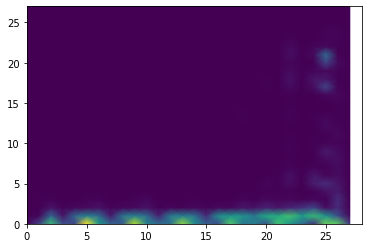

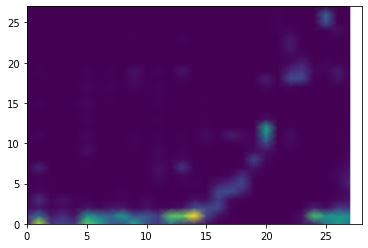

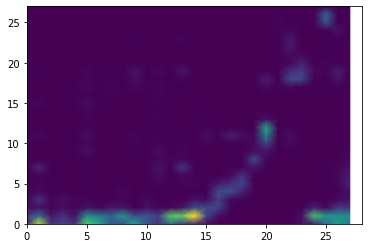

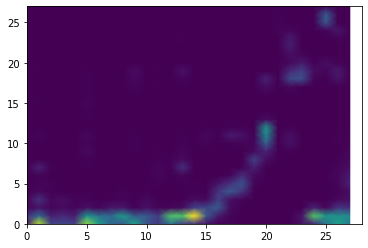

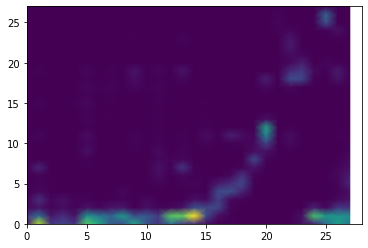

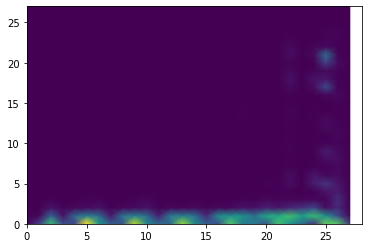

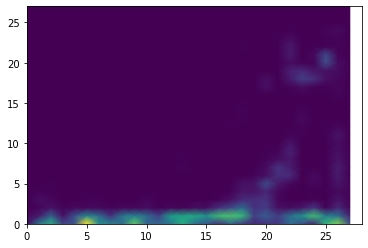

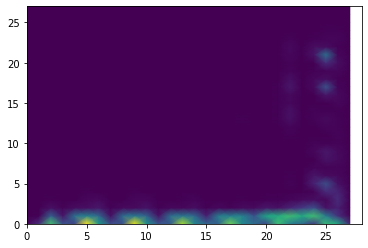

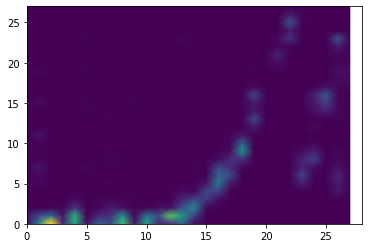

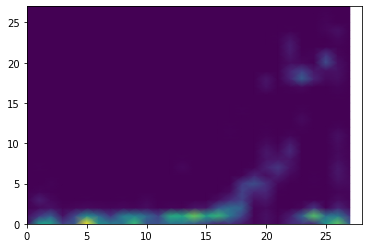

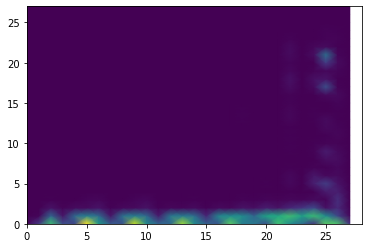

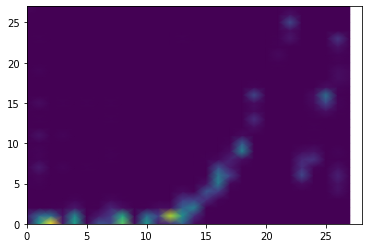

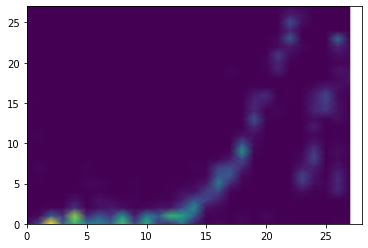

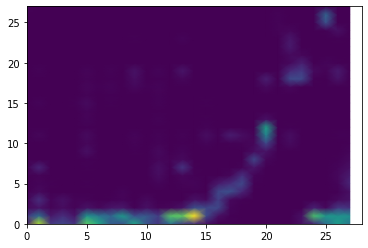

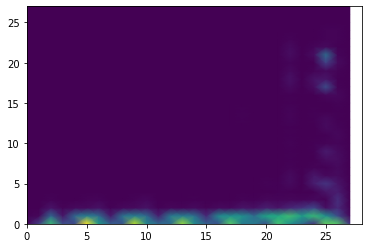

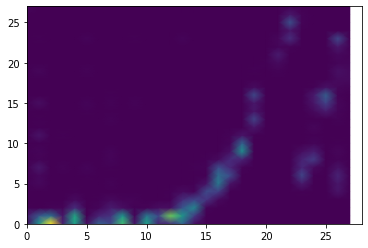

In [ ]:
images.shape
for i in images:
    plot_sg(i[0])
    plt.show()